In [1]:
%load_ext autoreload
%autoreload 2
%load_ext google.cloud.bigquery

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from GomokuBoard import GomokuBoard
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt
from HeuristicPolicy import HeuristicGomokuPolicy

from google.cloud import bigquery
import google.datalab.bigquery as bq

In [4]:
A,B,C,D,E,F,G,H,I, J, K, L, M, N, O, P, Q, R, S, T, U = \
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK, WHITE, EDGES = 0,1,2

In [5]:
stones = gt.string_to_stones('e10g8g5f5f6e7f7f8e8g9h10d9g10f10h8h9i9g7e9j8h11i12e11e12g11f11f12e13g13h14i10g14j9k8i8k4i7')

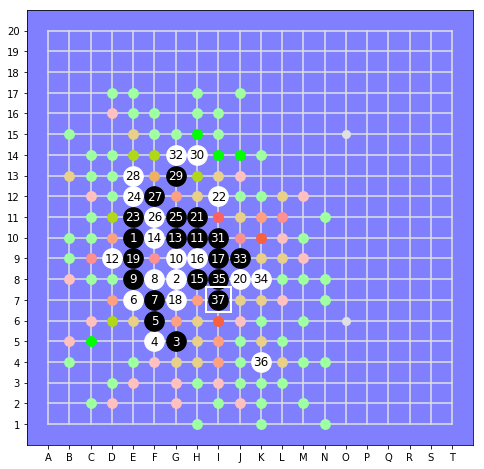

In [6]:
b = GomokuBoard(heuristics=Heuristics(kappa=3), N=20, stones=stones, disp_width=8)
b.display('current')

In [7]:
sum(1 for _ in tf.python_io.tf_record_iterator("gs://gomoku-data/tfrecords/games_tfr-00000-of-00001"))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


13000

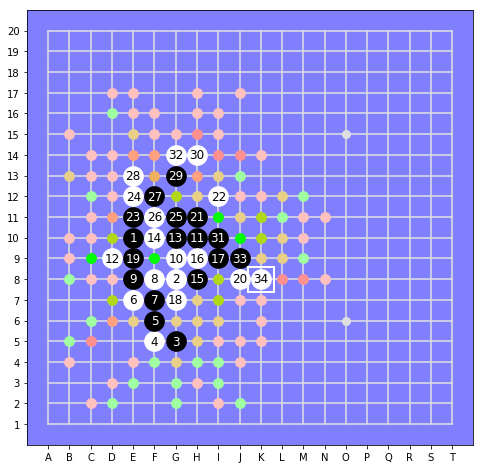

In [364]:
from copy import deepcopy
board = deepcopy(b)

board.undo().undo().undo()
#.undo().undo()
#.undo().undo().undo().undo().undo().undo().undo().undo()
 #.undo().undo().undo().undo().undo().undo().undo().undo().undo().undo())
offensive = HeuristicGomokuPolicy(board=board, style=0)
defensive = HeuristicGomokuPolicy(board=board, style=1)
board.display('current')


In [365]:
def is_threat(policy, x, y):
    policy.board.set(x,y)
    mcp = policy.most_critical_pos()
    policy.board.undo()
    return mcp

In [366]:
sampler = offensive.suggest_from_score(10, 0, 2.0)

In [367]:
sampler.choices

[(0.7513690519577025, (10, 9), 0.24863094804229738, 5.936837414520608),
 (0.627917271159974, (10, 10), 0.1234517807977286, 5.586777904672785),
 (0.5238488100047661, (11, 5), 0.10406846115520788, 5.50137706565594),
 (0.4197803488495583, (10, 3), 0.10406846115520788, 5.50137706565594),
 (0.31571188769435043, (7, 5), 0.10406846115520788, 5.50137706565594),
 (0.21192965041659487, (11, 2), 0.10378223727775554, 5.499999999999999),
 (0.10814741313883933, (8, 6), 0.10378223727775554, 5.499999999999999),
 (0.06109640580787687, (13, 8), 0.04705100733096246, 5.104468722001463),
 (0.014045398476914415, (12, 8), 0.04705100733096246, 5.104468722001463),
 (0.0, (13, 3), 0.014045398476914415, 4.5)]

In [368]:
def is_tseq_won(board, max_depth=3):
    board = deepcopy(board)
    policy = HeuristicGomokuPolicy(board=board, style=0)

    return _is_tseq_won(board, policy, max_depth, [])

def _is_tseq_won(board, policy, max_depth, moves):

    if max_depth < 1:
        return moves, False

    crit = policy.most_critical_pos() 
    if crit and crit.off_def == -1: # must defend, threat sequence is over
        #print(board.stones[-5:])
        #print("critical:" + str(crit)) 
        return moves, False
        
    sampler = policy.suggest_from_score(10, 0, 2.0)
    for c in sampler.choices:
        #print("checking move: " + str(c))
        x,y = gt.m2b((c[1][0],c[1][1]), 20)

        if is_threat(policy, x,y):
            board.set(x,y)
            moves.append((x,y))
            defense0 = policy.suggest()

            if defense0.status == -1: # The opponent gave up
                return moves, True     
            else: 
                #print(board.stones)
                #print("defense:" + str(defense0))
                #print(policy.defense_options(defense0.x, defense0.y))

                ######################## TODO: BUGGY ############################
                
                branches = []
                for defense in policy.defense_options(defense0.x, defense0.y):
                    # A single successful defense would make this branch useless

                    p = deepcopy(policy)
                    b = p.board
                    m = deepcopy(moves)
                    b.set(defense[0], defense[1])
                    m.append((defense[0], defense[1]))
                    branches.append(_is_tseq_won(b, p, max_depth-1, m))
                    
                won = np.all([br[1] for br in branches])
                                    
                if not won:
                    board.undo()
                    moves = moves[:-1]
                else:
                    return branches[0]
                    
    return moves, False

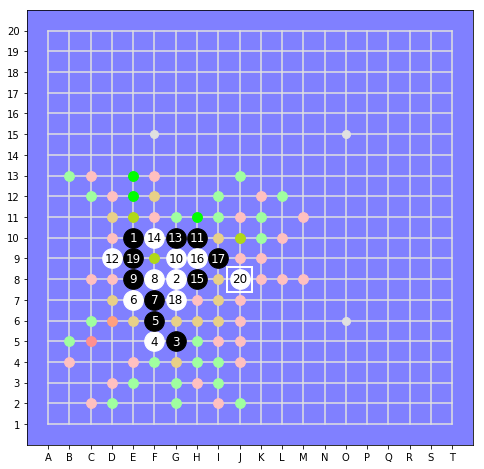

In [413]:
board = deepcopy(b)
(board.undo().undo().undo().undo().undo().undo().undo().undo().undo()
 .undo().undo().undo().undo().undo().undo().undo().undo())
board.display('current')

In [414]:
moves, won = is_tseq_won(board, 10)
moves, won

([(8, 11),
  (6, 9),
  (7, 11),
  (5, 11),
  (6, 12),
  (5, 13),
  (9, 11),
  (10, 11),
  (9, 10),
  (9, 8),
  (10, 10),
  (11, 10),
  (9, 12),
  (9, 13),
  (8, 12),
  (7, 13),
  (7, 12)],
 True)

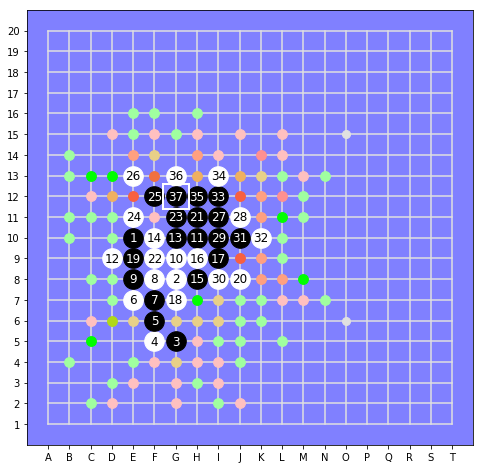

In [415]:
for x,y in moves:
    board.set(x,y)
board.display('current')

In [416]:
board.bwd(20);

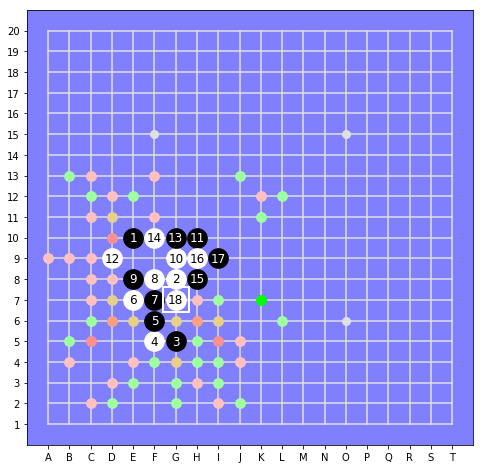

In [417]:
board.fwd().display('current')